# One shot learning (UNFINISHED, expected to be finished before September 5th 2016).

Imagine we have a bunch of classes, say 10 classes, and we'd like to perform a classification task. However, we only have a good amount of data for 7 classes out of 10. For the other 3 classes, there's only a very limited number of examples (say 1 or 2 examples for instance). The idea of *one shot learning* is to train a network on the classes for which we have a lot of data and use this trained network to classify examples from the classes for which it wasn't trained on. Here, we mostly follow the approach described in *Siamese Neural Networks for One-shot Image Recognition* by Koch et al.

We use a siamese architecture that we train on the MNIST data set. More specifically, we only train the netowk on digits from 0 to 6. The network will take two images and answer the following question: **do the two inputs belong to the same class?** After the training has been completed, we try to classify the digits 7, 8 and 9 by comparing the testing examples to the very limited labeled data we have for these classes.

For more details on *siamese architecture*, I refer the interested reader to the implementation of a siamese network in the notebook **siamese**.

In [34]:
import sys
import os
import tensorflow as tf
import numpy as np
import matplotlib.pyplot as plt
sys.path.insert(0, '../data_processing/')
from siamese_data import MNIST # load the data and process it
%matplotlib inline

We load the data.

In [2]:
data = MNIST()

## Learning a similarity metric with a siamese network

We are going to implement a siamese architecture similar to the one described in the **siamese notebook**, but we are going to use convolutional neural networks instead of LSTM.

In [3]:
n_inputs = 784 # dimension of each of the input vectors: 28*28
n_hidden = 128 # number of neurons of the bi-directional LSTM
n_classes = 2 # two possible classes, either `same` of `different`

In [4]:
x1 = tf.placeholder(tf.float32, shape=[None, n_inputs]) # placeholder for the first network (image 1)
x2 = tf.placeholder(tf.float32, shape=[None, n_inputs]) # placeholder for the second network (image 2)

# placeholder for the label. `[1, 0]` for `same` and `[0, 1]` for `different`.
y = tf.placeholder(tf.float32, shape=[None, n_classes])

# placeholder for dropout (we could use different dropouts for different part of the architecture)
keep_prob = tf.placeholder(tf.float32)

In [ ]:

tf.nn.conv2d()



In [5]:
with tf.variable_scope('siamese_network') as scope:
    with tf.name_scope('Bi_LSTM_1'):
        outputs1, last_state_fw1, last_state_bw1 = tf.nn.bidirectional_rnn(
                                        lstm_fw_cell, lstm_bw_cell, x1_,
                                        dtype=tf.float32)
    with tf.name_scope('Bi_LSTM_2'):
        scope.reuse_variables() # tied weights (reuse the weights from `Bi_LSTM_1` for `Bi_LSTM_2`)
        outputs2, last_state_fw2, last_state_bw2 = tf.nn.bidirectional_rnn(
                                        lstm_fw_cell, lstm_bw_cell, x2_,
                                        dtype=tf.float32)


# Weights and biases for the layer that connects the outputs from the two networks
weights = tf.get_variable('weigths_out', shape=[4 * n_hidden, n_classes],
                initializer=tf.random_normal_initializer(stddev=1.0/float(n_hidden)))
biases = tf.get_variable('biases_out', shape=[n_classes])

# We concatenate the different states of the cells for the first network and
# for the second network independently, and we compute the absolute difference
# between the states from the first network and the second network.
last_state1 = tf.concat(1, [last_state_fw1[0], last_state_bw1[0],
                              last_state_fw1[1], last_state_bw1[1]])
last_state2 = tf.concat(1, [last_state_fw2[0], last_state_bw2[0],
                              last_state_fw2[1], last_state_bw2[1]])
last_states_diff = tf.abs(last_state1 - last_state2)
logits = tf.matmul(last_states_diff, weights) + biases

In [6]:
logits = siamese_model(x1, x2, keep_prob) # Unscaled logits. They are scaled using softmax in the loss function
loss = tf.reduce_mean(tf.nn.softmax_cross_entropy_with_logits(logits, y))
optimizer = tf.train.AdamOptimizer().minimize(loss)

correct_pred = tf.equal(tf.argmax(logits, 1), tf.argmax(y, 1)) 
accuracy = tf.reduce_mean(tf.cast(correct_pred, tf.float32))

In [84]:
init = tf.initialize_all_variables()

max_iter = 10000 # maximum number of iterations for training
batch_train = 128 # batch size for training
batch_test = 512 # batch size for testing
display = 100 # display the training loss and accuracy every `display` step
n_test = 200 # test the network every `n_test` step

n_snapshot = 1000 # save the weights every `n_snapshot` step
checkpoint_dir = 'models/one_shot_learning/'
saver = tf.train.Saver() # to save the trained model

with tf.Session() as sess:
    sess.run(init) # initialize all variables
    print('Network training begins.')
    for i in range(1, max_iter + 1):
        # We retrieve a batch of data from the training set (digits between 0 and 6)
        batch_x1, batch_x2, batch_y = data.get_next_batch(batch_train, phase='train', one_shot=True)
        # We feed the data to the network for training
        feed_dict = {x1: batch_x1, x2: batch_x2, y: batch_y, keep_prob: .9}
        _, loss_, accuracy_ = sess.run([optimizer, loss, accuracy], feed_dict=feed_dict)
        
        if i % display == 0:
            print('step %i, training loss: %.5f, training accuracy: %.3f' % (i, loss_, accuracy_))
        
        # Testing the network
        if i % n_test == 0:
            # Retrieving data from the test set
            batch_x1, batch_x2, batch_y = data.get_next_batch(batch_test, phase='test', one_shot=True)
            feed_dict = {x1: batch_x1, x2: batch_x2, y: batch_y, keep_prob: 1.0}
            accuracy_test = sess.run(accuracy, feed_dict=feed_dict)
            print('testing step %i, accuracy %.3f' % (i, accuracy_test))
        
        # We save a snapshot of the weights
        if i % n_snapshot == 0:
            save_path = saver.save(sess, os.path.join(checkpoint_dir,'snapshot_') + str(i) + '.ckpt')
            print('Snapshot saved in file: %s' % save_path)

    print('********************************')
    print('Training finished.')

Network training begins.
step 100, training loss: 0.52368, training accuracy: 0.719
step 200, training loss: 0.32655, training accuracy: 0.891
testing step 200, accuracy 0.838
step 300, training loss: 0.23412, training accuracy: 0.930
step 400, training loss: 0.21807, training accuracy: 0.930
testing step 400, accuracy 0.900
step 500, training loss: 0.23719, training accuracy: 0.875
step 600, training loss: 0.21580, training accuracy: 0.938
testing step 600, accuracy 0.896
step 700, training loss: 0.23450, training accuracy: 0.898
step 800, training loss: 0.14737, training accuracy: 0.961
testing step 800, accuracy 0.930
step 900, training loss: 0.25219, training accuracy: 0.898
step 1000, training loss: 0.12850, training accuracy: 0.961
testing step 1000, accuracy 0.932
Snapshot saved in file: models/one_shot_learning/snapshot_1000.ckpt
step 1100, training loss: 0.12041, training accuracy: 0.930
step 1200, training loss: 0.14836, training accuracy: 0.945
testing step 1200, accuracy 0.

## One shot learning: using the pretrained similarity metric on new classes

We now want to see how the network performs on images from unseen classes, i.e. sevens, eights and nines.

Following the approach described by Koch et al., we chose 10 images ($i_0, i_1,...,i_9$), one per class. We then classify an image by comparing it pairwise with the images $i_0,...,i_9$.

But first, let's chose 10 reference images.

In [85]:
one_example_per_class = []
for digit in data.digits:
    one_example_per_class.append(getattr(data, digit)[np.random.randint(len(getattr(data, digit)))])

Below, we display the 10 images we use ($i_0,...,i_9$) as a benchmark for pairwise comparisons.

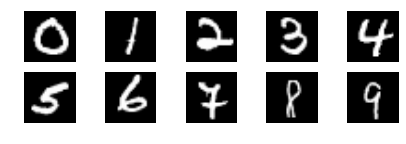

In [86]:
fig = plt.figure(figsize=(7,2))
for i in range(1, 11):
    a = fig.add_subplot(2, 5, i)
    a.axis('off')
    image = one_example_per_class[i - 1].reshape((28, 28)) # reshape the image from (784) to (28, 28).
    a.imshow(image, cmap='Greys_r');

We retrieve the model trained above, and we classify images of 7, 8 and 9 by comparing them with the benchmark images $i_0,...,i_9$. We report the accuracy of the classifcation on the *unseen* classes and on the *seen* classes.

In [87]:
def reshape_input(image):
    """
    Takes a `numpy array` of shape (784) and reshape it
    into a `numpy array` of shape (1, 28, 28).
    """
    return np.expand_dims(image.reshape((28,28)), axis=0)

def reshape_label(label):
    """
    Argss:
        label: a list of two elements.
    """
    if label[0] == label[1]:
        return np.expand_dims(np.asarray([1, 0]),axis=0)
    else:
        return np.expand_dims(np.asarray([0, 1]),axis=0)

In [91]:
def compare_two_digits(digit1, digit2, label1, label2, sess):
    true_y = 'different'
    if label1 == label2:
        true_y = 'same'
    label = reshape_label([label1, label2])
    feed_dict = {x1: digit1, x2: digit2, y: label, keep_prob: 1.0}
    logits_, accuracy_test = sess.run([logits, accuracy], feed_dict=feed_dict)
    predicted_y = 'different'
    if np.argmax(logits_[0]) == 0:
         predicted_y = 'same'
    return true_y, predicted_y

In [98]:
one_example_per_class = [reshape_input(x) for x in one_example_per_class]

In [113]:
checkpoint_dir = 'models/one_shot_learning/'
with tf.Session() as sess:
    latest_checkpoint = tf.train.latest_checkpoint(checkpoint_dir=checkpoint_dir)
    saver.restore(sess, latest_checkpoint)
    print('%s was restored.' % latest_checkpoint)
    digit1 = reshape_input(data.sevens[100])
    for i in range(10):
        digit2 = reshape_input(one_example_per_class[i])
        true_y, predicted_y = compare_two_digits(digit1, digit2, 7, i, sess)
        print 'Comparing %i with 7:' %i, predicted_y

models/one_shot_learning/snapshot_10000.ckpt was restored.
Comparing 0 with 7: different
Comparing 1 with 7: different
Comparing 2 with 7: same
Comparing 3 with 7: same
Comparing 4 with 7: different
Comparing 5 with 7: different
Comparing 6 with 7: different
Comparing 7 with 7: different
Comparing 8 with 7: same
Comparing 9 with 7: different


In [74]:
a = [[ 2.24756432,  0.03931087]]
a[0]

[2.24756432, 0.03931087]